In [ ]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.2 MB/s eta 0:00:00


In [ ]:
# Import libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # play sound in the notebook
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import shutil
from pathlib import Path
from tqdm.auto import tqdm # progress bars in notebooks
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/UCB/207/Final_Project/Data/Speech/"

Actor_01  Actor_04  Actor_07  Actor_10	Actor_13  Actor_16  Actor_19  Actor_22
Actor_02  Actor_05  Actor_08  Actor_11	Actor_14  Actor_17  Actor_20  Actor_23
Actor_03  Actor_06  Actor_09  Actor_12	Actor_15  Actor_18  Actor_21  Actor_24


In [ ]:
def consolidate_files(source_dir: str, dest_dir: str, extension: str = ".wav"):

    source_path = Path(source_dir)
    dest_path = Path(dest_dir)

    # destination directory
    dest_path.mkdir(parents=True, exist_ok=True)
    print(f"Consolidated directory is at: {dest_path.resolve()}")

    files_to_copy = list(source_path.rglob(f'*{extension}'))

    if not files_to_copy:
        print(f"No '{extension}' files found in the source directory.")
        return

    #Copy files with a tqdm progress bar
    copied_count = 0
    print(f"Found {len(files_to_copy)} files to copy...")

    for source_file in tqdm(files_to_copy, desc="Copying files", unit="file"):
        if source_file.parent.resolve() == dest_path.resolve():
            continue

        try:
            #shutil.copy2 to preserve metadata
            shutil.copy2(source_file, dest_path)
            copied_count += 1
        except Exception as e:
            print(f"\nCould not copy {source_file.name}. Error: {e}")

    print(f"\nFinished. Copied {copied_count} of {len(files_to_copy)} files.")


In [ ]:
RAV = "/content/drive/MyDrive/UCB/207/Final_Project/Data/Speech"
Target_dir = RAV + '/All_Actors_Speech_test'

In [ ]:
# Excute only once for speech or song
consolidate_files(RAV, Target_dir, extension=".wav")

In [ ]:
print(f"Number of files in RAV directory: {len(list(Path(RAV).rglob('*.wav')))}")

Number of files in RAV directory: 1440


In [ ]:
phrase_map = {1: "Kids are talking by the door", 2: "Dogs are sitting by the door"}

emotion_map = {
    1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}

file_paths = glob.glob(os.path.join(RAV, 'Actor_*', '*.wav'))

processed_data = []
for file_path in file_paths:
    # filename from path
    filename = os.path.basename(file_path)

    parts = filename.split('.')[0].split('-')

    #  metadata for one file
    emotion = emotion_map[int(parts[2])]
    gender = "female" if int(parts[6]) % 2 == 0 else "male"
    phrase = phrase_map[int(parts[4])]

    # Append a dictionary
    processed_data.append({
        'labels': f"{gender}_{emotion}",
        'path': file_path,
        'phrase': phrase
    })

#DataFrame
RAV_df = pd.DataFrame(processed_data)

display(RAV_df.head())

,labels,path,phrase
0,male_neutral,/content/drive/MyDrive/UCB/207/Final_Project/D...,Kids are talking by the door
1,male_neutral,/content/drive/MyDrive/UCB/207/Final_Project/D...,Kids are talking by the door
2,male_neutral,/content/drive/MyDrive/UCB/207/Final_Project/D...,Kids are talking by the door
3,male_neutral,/content/drive/MyDrive/UCB/207/Final_Project/D...,Kids are talking by the door
4,male_neutral,/content/drive/MyDrive/UCB/207/Final_Project/D...,Dogs are sitting by the door


In [ ]:
RAV_df.labels.value_counts()

,count
labels,
male_neutral,144
female_neutral,144
male_happy,96
male_fear,96
male_angry,96
male_sad,96
male_disgust,96
male_surprise,96
female_happy,96


<Figure size 1200x600 with 0 Axes>

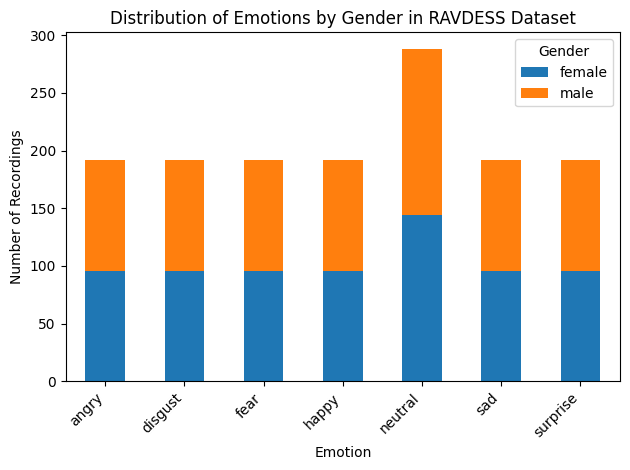

In [ ]:
# emotion and gender from labels
RAV_df[['gender_split', 'emotion_split']] = RAV_df['labels'].str.split('_', expand=True)

# Group by emotion and gender, and count the occurrences
emotion_gender_counts = RAV_df.groupby(['emotion_split', 'gender_split']).size().unstack(fill_value=0)

# stacked bar chart
plt.figure(figsize=(12, 6))
emotion_gender_counts.plot(kind='bar', stacked=True)
plt.title('Distribution of Emotions by Gender in RAVDESS Dataset')
plt.xlabel('Emotion')
plt.ylabel('Number of Recordings')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

<Figure size 1500x700 with 0 Axes>

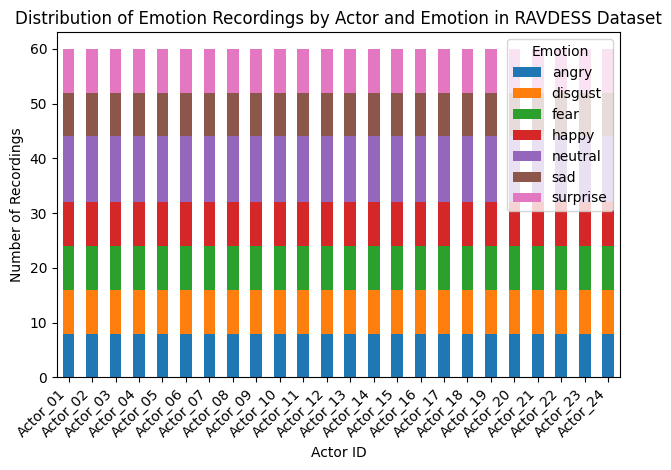

In [ ]:
# actor ID from the path
RAV_df['actor_id'] = RAV_df['path'].apply(lambda x: x.split('/')[-2])

# emotion from labels
if 'emotion_split' not in RAV_df.columns:
  RAV_df[['gender_split', 'emotion_split']] = RAV_df['labels'].str.split('_', expand=True)

# Group by actor and emotion, and count the occurrences
actor_emotion_counts = RAV_df.groupby(['actor_id', 'emotion_split']).size().unstack(fill_value=0)

# stacked bar chart
plt.figure(figsize=(15, 7))
actor_emotion_counts.plot(kind='bar', stacked=True)
plt.title('Distribution of Emotion Recordings by Actor and Emotion in RAVDESS Dataset')
plt.xlabel('Actor ID')
plt.ylabel('Number of Recordings')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Emotion')
plt.tight_layout()
plt.show()

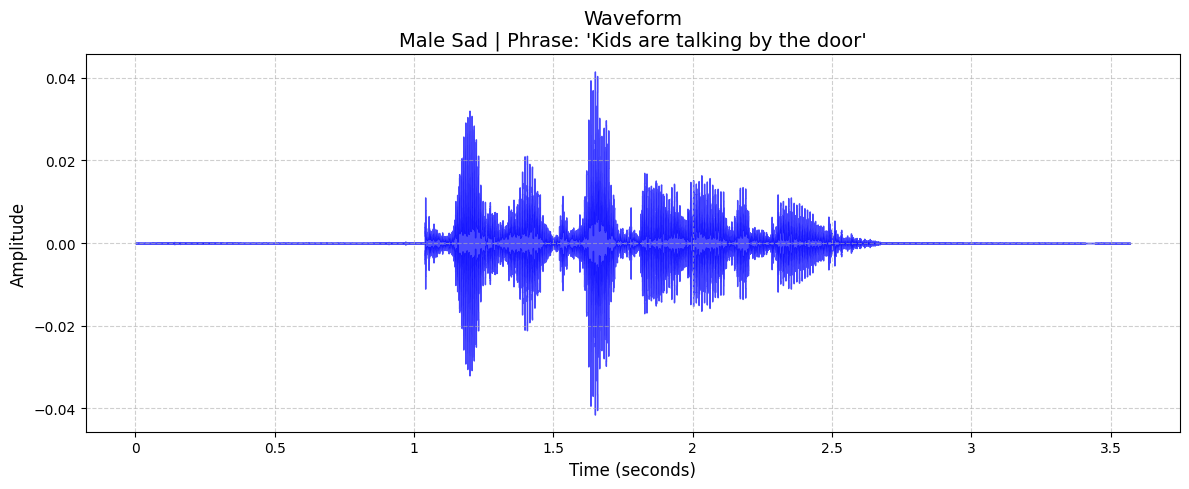

In [ ]:
#sample file plot
sample_file = RAV_df.iloc[10]
file_path = sample_file['path']
label = sample_file['labels'].replace('_', ' ').title() # Format for title
phrase = sample_file['phrase']

# audio file
y, sr = librosa.load(file_path)

# plot
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y, sr=sr, color='blue', alpha=0.7)

# title and labels
plt.title(f"Waveform\n{label} | Phrase: '{phrase}'", fontsize=14)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

# audio
ipd.Audio(data=y, rate=sr)

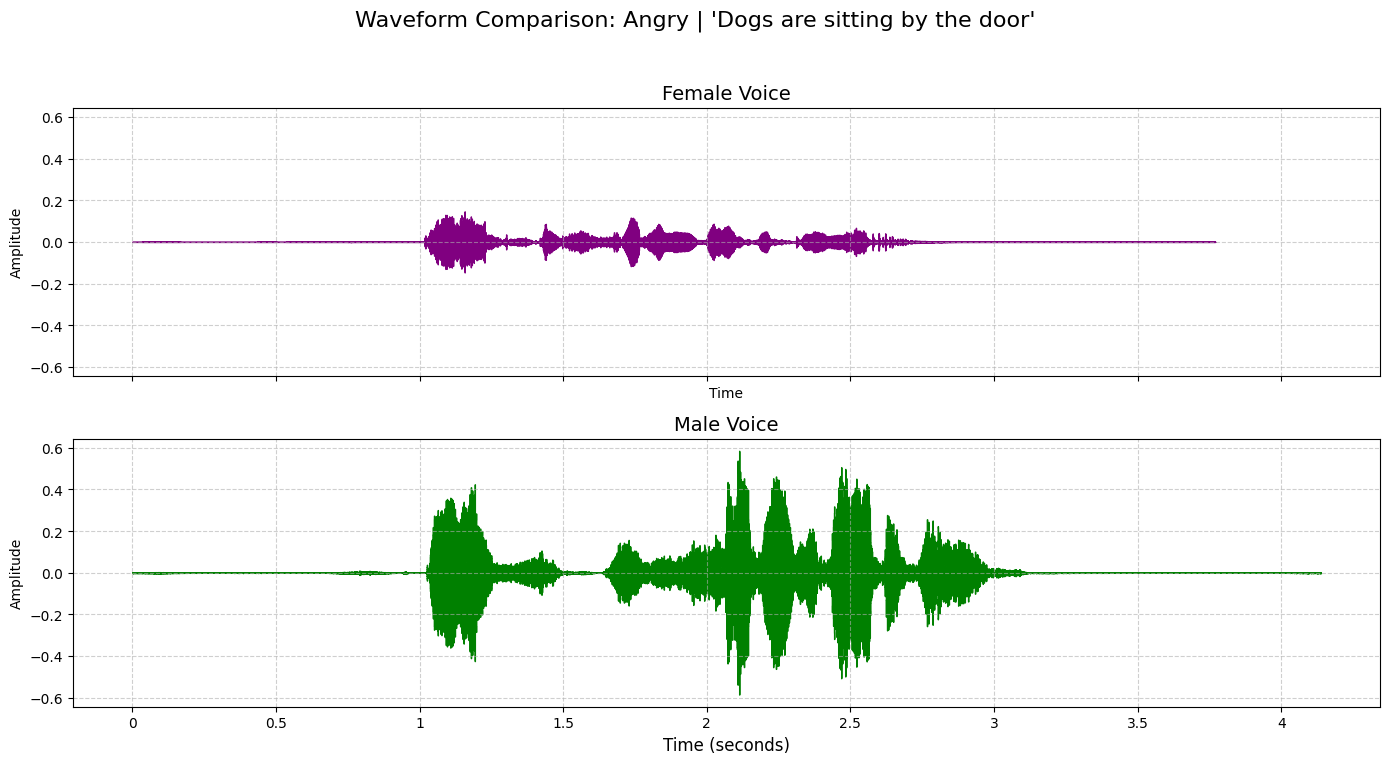

In [ ]:
female_sample = RAV_df[(RAV_df['labels'] == 'female_angry') & (RAV_df['phrase'].str.contains("Dogs"))].iloc[0]
male_sample = RAV_df[(RAV_df['labels'] == 'male_angry') & (RAV_df['phrase'] == female_sample['phrase'])].iloc[0]

# audio files
y_female, sr_female = librosa.load(female_sample['path'])
y_male, sr_male = librosa.load(male_sample['path'])

# Waveforms
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True, sharey=True)
fig.suptitle(f"Waveform Comparison: Angry | '{female_sample['phrase']}'", fontsize=16)

# Female Waveform
librosa.display.waveshow(y_female, sr=sr_female, ax=axes[0], color='purple')
axes[0].set_title("Female Voice", fontsize=14)
axes[0].set_ylabel("Amplitude")
axes[0].grid(True, linestyle='--', alpha=0.6)

# Male Waveform
librosa.display.waveshow(y_male, sr=sr_male, ax=axes[1], color='green')
axes[1].set_title("Male Voice", fontsize=14)
axes[1].set_ylabel("Amplitude")
axes[1].set_xlabel("Time (seconds)", fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for the main title
plt.show()

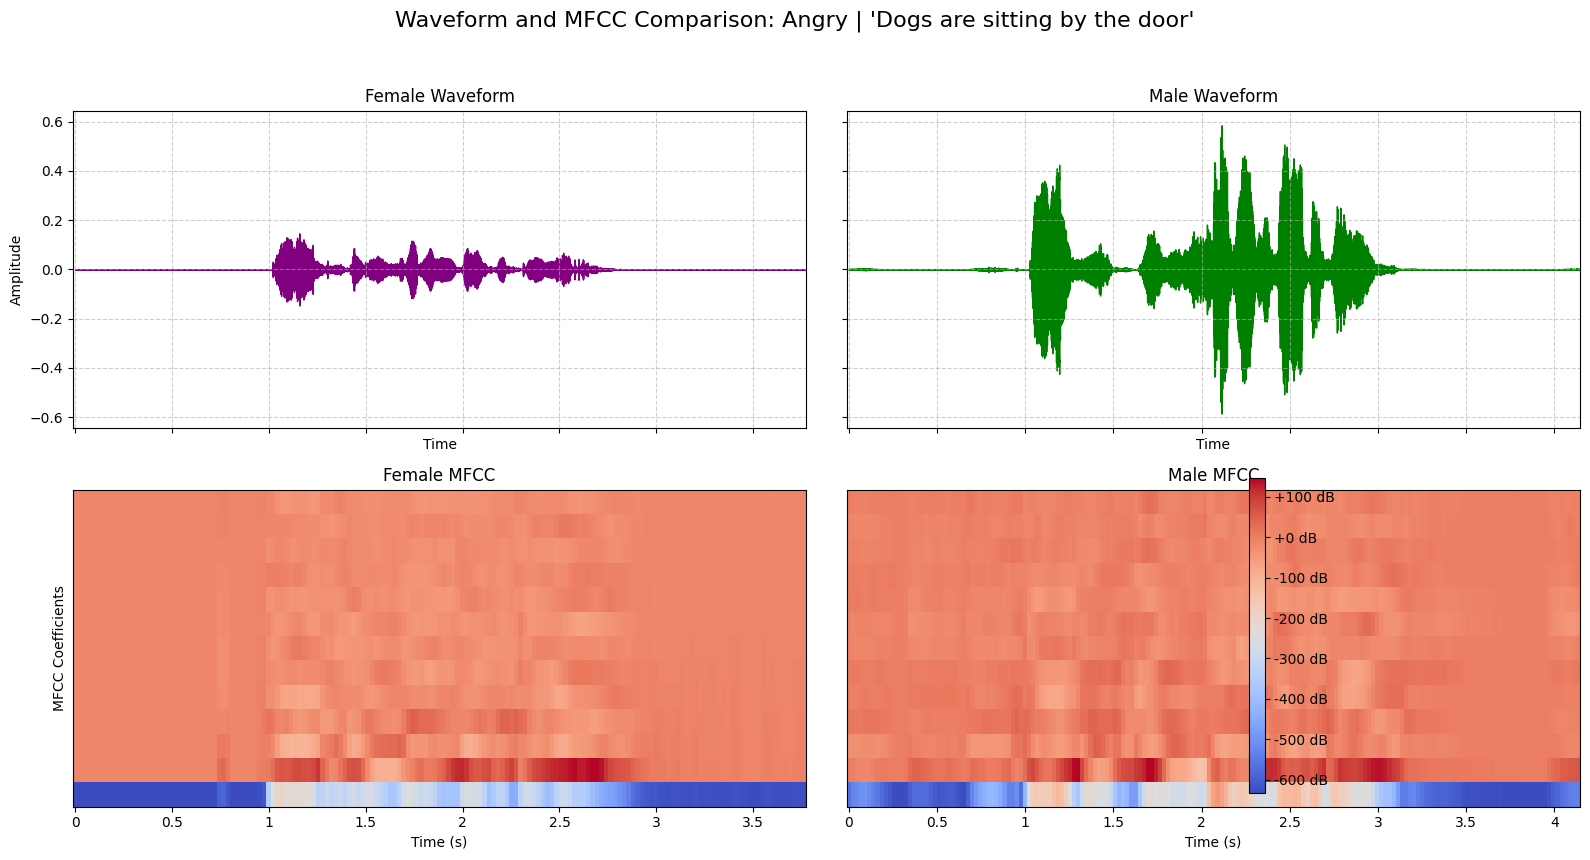

In [ ]:

female_sample = RAV_df[(RAV_df['labels'] == 'female_angry') & (RAV_df['phrase'].str.contains("Dogs"))].iloc[0]
male_sample = RAV_df[(RAV_df['labels'] == 'male_angry') & (RAV_df['phrase'] == female_sample['phrase'])].iloc[0]

# Load data
y_female, sr_female = librosa.load(female_sample['path'])
y_male, sr_male = librosa.load(male_sample['path'])

# MFCCs for both audio files
mfccs_female = librosa.feature.mfcc(y=y_female, sr=sr_female, n_mfcc=13)
mfccs_male = librosa.feature.mfcc(y=y_male, sr=sr_male, n_mfcc=13)

# 2x2 plot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharex='col', sharey='row')
fig.suptitle(f"Waveform and MFCC Comparison: Angry | '{female_sample['phrase']}'", fontsize=16)

# Waveforms
librosa.display.waveshow(y_female, sr=sr_female, ax=axes[0, 0], color='purple')
axes[0, 0].set_title("Female Waveform")
axes[0, 0].set_ylabel("Amplitude")
axes[0, 0].grid(True, linestyle='--', alpha=0.6)

librosa.display.waveshow(y_male, sr=sr_male, ax=axes[0, 1], color='green')
axes[0, 1].set_title("Male Waveform")
axes[0, 1].grid(True, linestyle='--', alpha=0.6)

# MFCCs
img1 = librosa.display.specshow(mfccs_female, sr=sr_female, x_axis='time', ax=axes[1, 0])
axes[1, 0].set_title("Female MFCC")
axes[1, 0].set_ylabel("MFCC Coefficients")
axes[1, 0].set_xlabel("Time (s)")

img2 = librosa.display.specshow(mfccs_male, sr=sr_male, x_axis='time', ax=axes[1, 1])
axes[1, 1].set_title("Male MFCC")
axes[1, 1].set_xlabel("Time (s)")

# colorbar
fig.colorbar(img2, ax=[axes[1, 0], axes[1, 1]], format='%+2.0f dB')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

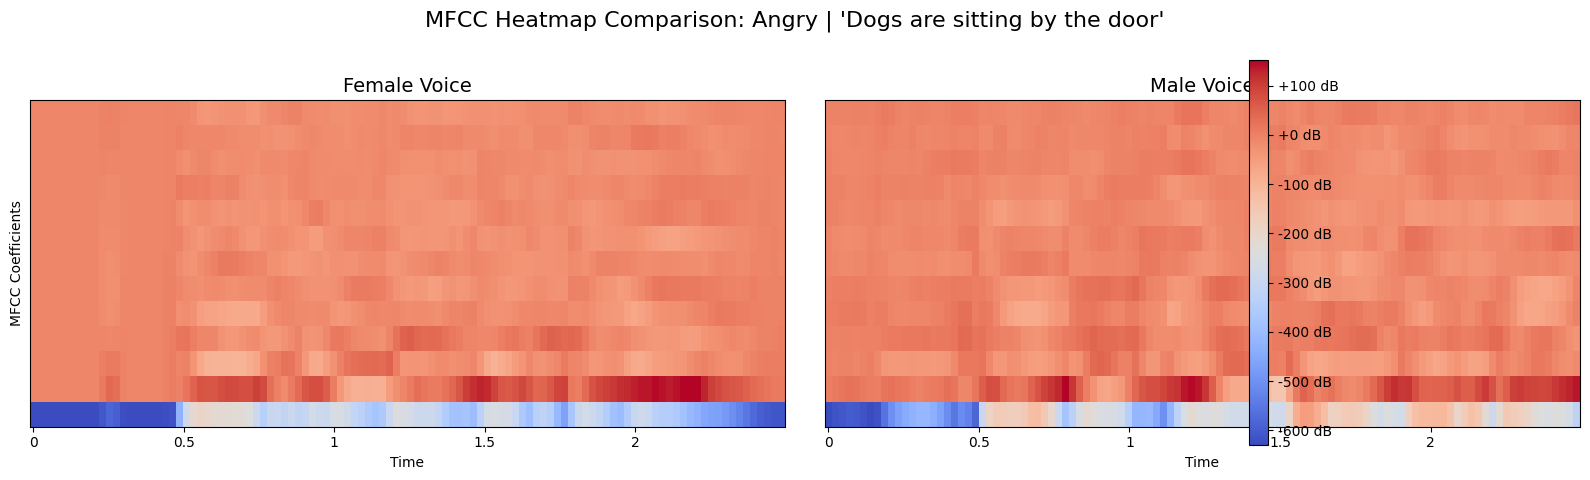

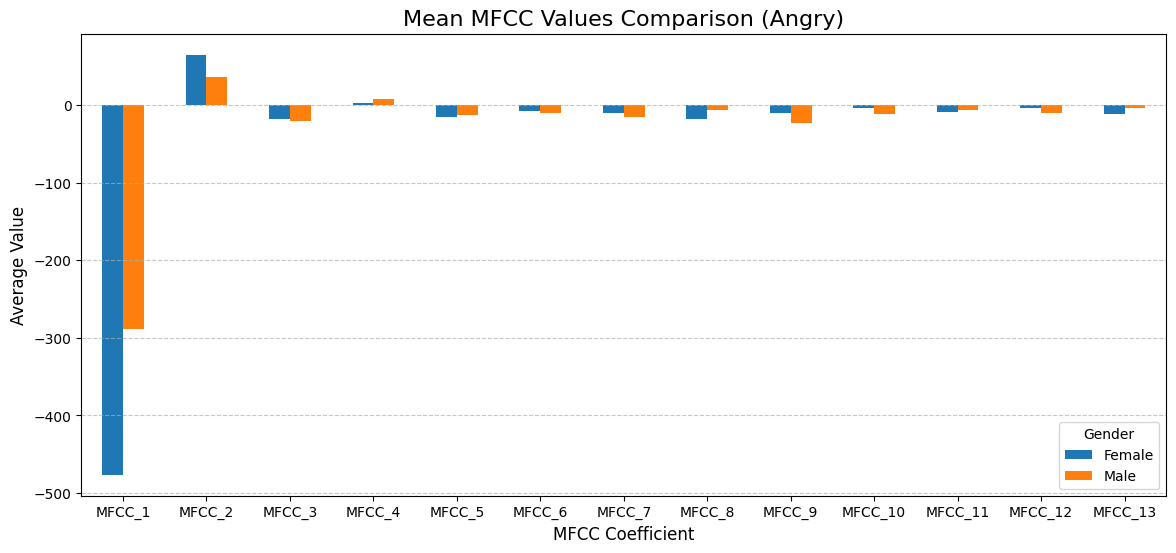

In [ ]:
female_sample = RAV_df[(RAV_df['labels'] == 'female_angry') & (RAV_df['phrase'].str.contains("Dogs"))].iloc[0]
male_sample = RAV_df[(RAV_df['labels'] == 'male_angry') & (RAV_df['phrase'] == female_sample['phrase'])].iloc[0]

# load audio and extract MFCCs
def get_mfccs(path, sr=22050, n_mfcc=13, duration=2.5):
    y, sr = librosa.load(path, sr=sr, duration=duration, offset=0.5)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfccs

# MFCCs for both files
female_mfccs = get_mfccs(female_sample['path'])
male_mfccs = get_mfccs(male_sample['path'])

# MFCC Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
fig.suptitle(f"MFCC Heatmap Comparison: Angry | '{female_sample['phrase']}'", fontsize=16)

# Female MFCC
librosa.display.specshow(female_mfccs, sr=22050, x_axis='time', ax=axes[0])
axes[0].set_title("Female Voice", fontsize=14)
axes[0].set_ylabel("MFCC Coefficients")

# Male MFCC
img = librosa.display.specshow(male_mfccs, sr=22050, x_axis='time', ax=axes[1])
axes[1].set_title("Male Voice", fontsize=14)

fig.colorbar(img, ax=axes, format='%+2.0f dB')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

# average MFCCs
female_mfccs_mean = np.mean(female_mfccs, axis=1)
male_mfccs_mean = np.mean(male_mfccs, axis=1)

# DataFrame
df_mfcc_mean = pd.DataFrame({
    'Female': female_mfccs_mean,
    'Male': male_mfccs_mean,
}, index=[f'MFCC_{i}' for i in range(1, 14)])

# bar chart
df_mfcc_mean.plot(kind='bar', figsize=(14, 6), rot=0)
plt.title("Mean MFCC Values Comparison (Angry)", fontsize=16)
plt.xlabel("MFCC Coefficient", fontsize=12)
plt.ylabel("Average Value", fontsize=12)
plt.legend(title="Gender")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
def extract_features(audio_path):
    try:
        # Load audio file and resample
        X, sample_rate = librosa.load(audio_path, sr=22050)

        # Silence Trimming
        y_trimmed, _ = librosa.effects.trim(X, top_db=20)

        # Normalization
        y_normalized = librosa.util.normalize(y_trimmed)

        # MFCCs
        mfccs = np.mean(librosa.feature.mfcc(y=y_normalized, sr=sample_rate, n_mfcc=40).T, axis=0)

        # Mel Spectrogram
        mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=y_normalized, sr=sample_rate).T, axis=0)

        # Chroma Features
        chroma = np.mean(librosa.feature.chroma_stft(y=y_normalized, sr=sample_rate).T, axis=0)

        return np.concatenate((mfccs, mel_spectrogram, chroma))

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# feature extraction to the DataFrame
features = RAV_df['path'].apply(extract_features)

# Remove rows where feature extraction failed
RAV_df['features'] = features
RAV_df = RAV_df.dropna(subset=['features'])

# DataFrame with features as columns
features_df = pd.DataFrame(RAV_df['features'].values.tolist())

# Concatenate with the original DataFrame
RAV_df = pd.concat([RAV_df.drop('features', axis=1), features_df], axis=1)

display(RAV_df.head())

,labels,path,phrase,gender_split,emotion_split,actor_id,0,1,2,3,...,170,171,172,173,174,175,176,177,178,179
0,male_neutral,/content/drive/MyDrive/UCB/207/Final_Project/D...,Kids are talking by the door,male,neutral,Actor_01,-171.874985,126.957199,5.818597,24.317835,...,0.390853,0.360256,0.413479,0.502948,0.492705,0.613504,0.541942,0.373253,0.364334,0.417731
1,male_neutral,/content/drive/MyDrive/UCB/207/Final_Project/D...,Kids are talking by the door,male,neutral,Actor_01,-175.194763,119.905312,-6.976892,29.602516,...,0.380293,0.247335,0.273133,0.336189,0.220400,0.315400,0.379676,0.466522,0.470828,0.408921
2,male_neutral,/content/drive/MyDrive/UCB/207/Final_Project/D...,Kids are talking by the door,male,neutral,Actor_01,-161.491150,128.661545,-10.988075,26.386919,...,0.340473,0.323500,0.347692,0.296275,0.302750,0.376805,0.464146,0.472452,0.428129,0.359247
3,male_neutral,/content/drive/MyDrive/UCB/207/Final_Project/D...,Kids are talking by the door,male,neutral,Actor_01,-171.102570,121.396828,1.188169,27.899853,...,0.434722,0.347075,0.304361,0.317916,0.296400,0.387565,0.443473,0.478387,0.518938,0.407613
4,male_neutral,/content/drive/MyDrive/UCB/207/Final_Project/D...,Dogs are sitting by the door,male,neutral,Actor_01,-179.428314,122.867676,-6.031170,29.281153,...,0.352087,0.406483,0.350252,0.217137,0.189262,0.330606,0.458145,0.451519,0.310909,0.303836
